In [1]:
pip install mplcyberpunk rapidfuzz

Note: you may need to restart the kernel to use updated packages.


In [2]:
%autosave 60

Autosaving every 60 seconds


# КТ №2 по ML | Серкибаев Аким, Э-2209

## Мой гитхаб, где размещены все работы
Ссылка на гитхаб: [ссылочка (тык)](https://github.com/akim-norfeg)

## Задание
Необходимо провести разведочный анализ данных и применить изученные модели (не обязательно все), добившись наилучшего качества прогноза на тестовой выборке. Необходимо выбрать метрику, обосновав выбор. Target - Price

## Цель исследования
Построить регрессионную модель, максимально точно предсказывающую цену (Price) подержанного автомобиля на тестовой выборке и отобрать метрику качества прогноза, обосновав её выбор

### Описание столбцов датасета

| Column               | Description                                    |
|----------------------|------------------------------------------------|
| Name                 | Бренд и модель автомобиля                      |
| Location             | Город продажи                                  |
| Year                 | Год выпуска автомобиля                         |
| Kilometers_Driven    | Пробег в километрах                            |
| Fuel_Type            | Тип используемого топлива                      |
| Transmission         | Тип коробки передач                            |
| Owner_Type           | Категория предыдущего владельца                |
| Mileage              | Расход топлива с указанием единицы измерения   |
| Engine               | Объём двигателя в кубических сантиметрах       |
| Power                | Мощность двигателя в лошадиных силах           |
| Seats                | Количество посадочных мест                     |
| New_Price            | Цена автомобиля при покупке новым              |
| Price                | Цена подержанного автомобиля (целевой признак) |


In [3]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use('cyberpunk')

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import warnings

import missingno as msno
from rapidfuzz import process, fuzz

from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [4]:
pd.set_option('display.max_columns', None) #max отображение столбцов
pd.set_option('max_colwidth', 555) #полное отображение записей в датасете
pd.set_option('display.max_colwidth', None) #показывает все символы в строках
warnings.filterwarnings('ignore') #отключим предупреждения

In [5]:
data_dir = '/kaggle/input/dataset-price-car'

#находим CSV-файл
files = os.listdir(data_dir)
csv_files = [f for f in files if f.endswith('.csv')]
assert len(csv_files) == 1, "В папке должно быть ровно 1 CSV-файл"
file_path = os.path.join(data_dir, csv_files[0])

In [6]:
df = pd.read_csv(file_path)

## Предобработка данных

In [7]:
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [8]:
print("Размерность датасета:", df.shape)
print("\nТипы данных по столбцам:\n", df.dtypes)
print(f"\nЧисло полных дубликатов строк: {df.duplicated().sum()}")

Размерность датасета: (6019, 13)

Типы данных по столбцам:
 Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
New_Price             object
Price                float64
dtype: object

Число полных дубликатов строк: 0


Число пропусков по каждому столбцу

In [9]:
print(df.isnull().sum())

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


<Axes: >

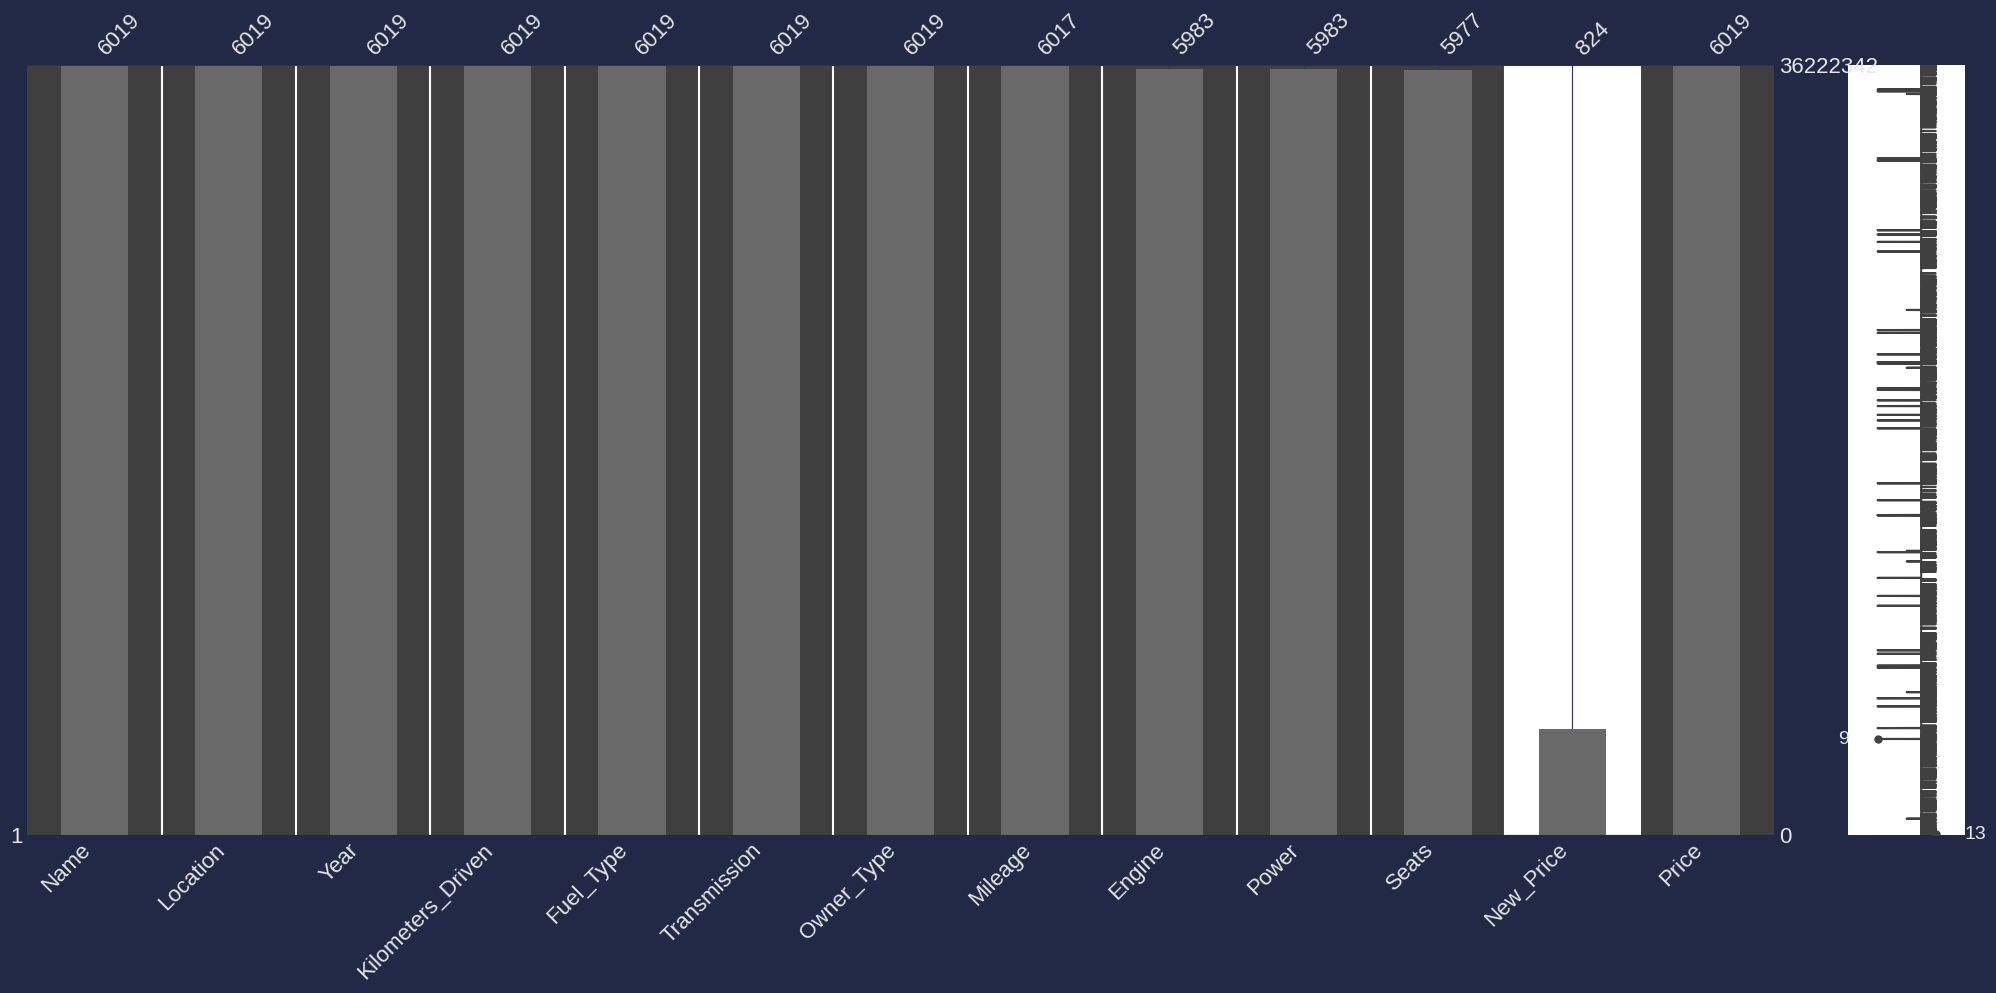

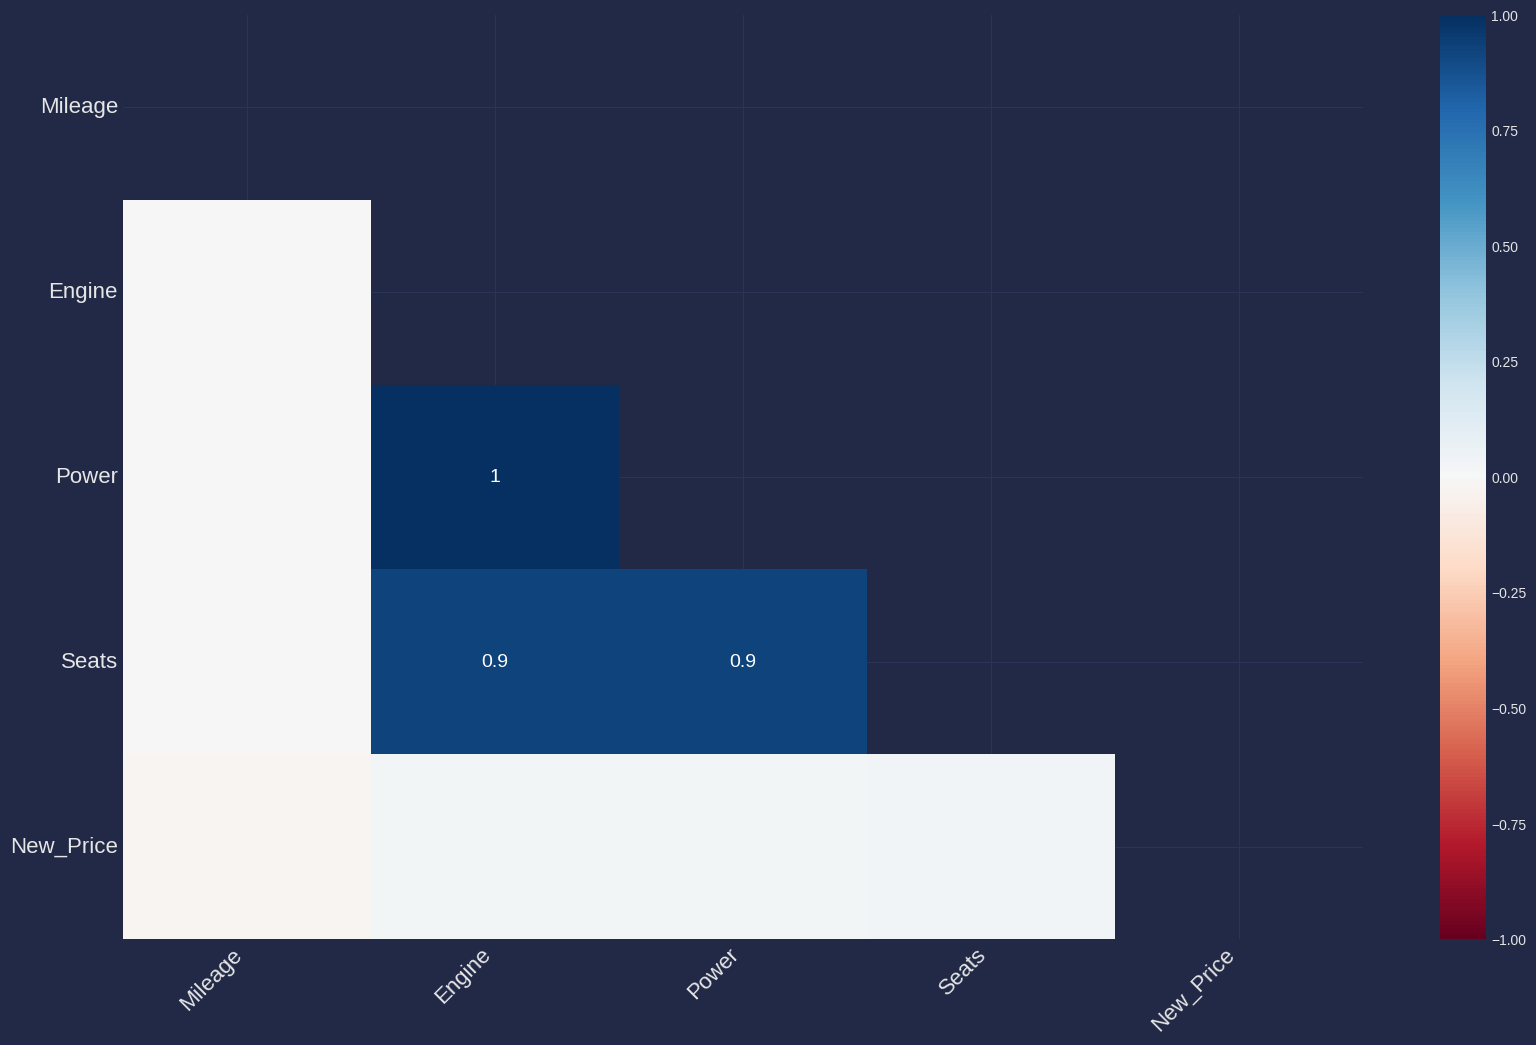

In [11]:
msno.matrix(df)
msno.bar(df)
msno.heatmap(df)

In [12]:
df.head(1)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75


### Далее обработаем данные, сделаем всё красиво:
1. **Преобразование строковых признаков в числовые**  
   - `Mileage`, `Engine`, `Power` содержат и число, и единицу. Модели нужны только численные значения:  
     - **`Mileage_Value`** (float) и **`Mileage_Unit`** (category) из `Mileage`  
     - **`Engine_CC`** (float) из `Engine`  
     - **`Power_BHP`** (float) из `Power` (с предварительной заменой «null bhp» на NaN)  
   - Без этого шага модель не «увидит» зависимость между пробегом, объёмом/мощностью двигателя и ценой.

2. **Вычисление возраста автомобиля**  
   - Новый признак **`Age = 2025 – Year`** обычно сильнее коррелирует с ценой, чем сам год выпуска.

3. **Промежуточный анализ пропусков**  
   - После извлечения чисел важно оценить оставшиеся NaN в `Mileage_Value`, `Engine_CC`, `Power_BHP`, `Seats`:  
     - На их основе выберем стратегию заполнения (медиана в группах).

4. **Дополнительный признак `New_Price_Lakh`**  
   - Преобразование `New_Price` в числовой формат позволяет анализировать отклонение текущей цены от изначальной, но из-за 86 % пропусков в модели напрямую использовать его не будем.

In [13]:
#числовые и текстовые части из Mileage
df['Mileage_Value'] = df['Mileage'].str.split().str[0].astype(float)
df['Mileage_Unit']  = df['Mileage'].str.split().str[1]
df.head(1)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Value,Mileage_Unit
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75,26.6,km/kg


In [14]:
#CC из Engine
df['Engine_CC'] = df['Engine'].str.extract(r'(\d+)').astype(float)
df.head(1)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Value,Mileage_Unit,Engine_CC
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75,26.6,km/kg,998.0


In [15]:
#BHP из Power
#некоторые значений Power могут быть 'null bhp', поэтому сначала заменим нечисловые на NaN
df['Power'] = df['Power'].replace('null bhp', np.nan)
df['Power_BHP'] = df['Power'].str.extract(r'([\d\.]+)').astype(float)

In [16]:
def parse_price_to_lakh(x):
    if pd.isna(x):
        return np.nan
    x = x.strip()
    if x.endswith('Cr'):
        #1 Cr = 100 Lakh
        return float(x.replace(' Cr', '')) * 100
    if x.endswith('Lakh'):
        return float(x.replace(' Lakh', ''))
    return np.nan

df['New_Price_Lakh'] = df['New_Price'].apply(parse_price_to_lakh)

print("Пропуски в New_Price_Lakh:", df['New_Price_Lakh'].isnull().sum())
df.sample(1)

Пропуски в New_Price_Lakh: 5195


,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Value,Mileage_Unit,Engine_CC,Power_BHP,New_Price_Lakh
4440,Hyundai Verna 1.6 CRDi AT S,Chennai,2016,33000,Diesel,Automatic,First,19.08 kmpl,1582 CC,126.2 bhp,5.0,NaN,8.7,19.08,kmpl,1582.0,126.2,NaN


In [17]:
#возраст
current_year = 2025
df['Age'] = current_year - df['Year']
df.head(1)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Value,Mileage_Unit,Engine_CC,Power_BHP,New_Price_Lakh,Age
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75,26.6,km/kg,998.0,58.16,NaN,15


In [18]:
print("Новые столбцы и их типы:")
print(df[['Mileage_Value','Mileage_Unit','Engine_CC','Power_BHP','New_Price_Lakh','Age']].dtypes)

Новые столбцы и их типы:
Mileage_Value     float64
Mileage_Unit       object
Engine_CC         float64
Power_BHP         float64
New_Price_Lakh    float64
Age                 int64
dtype: object


In [19]:
print("Пропуски после парсинга:")
print(df[['Mileage_Value','Engine_CC','Power_BHP','Seats']].isnull().sum())

Пропуски после парсинга:
Mileage_Value      2
Engine_CC         36
Power_BHP        143
Seats             42
dtype: int64


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5876 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
 13  Mileage_Value      6017 non-null   float64
 14  Mileage_Unit       6017 non-null   object 
 15  Engine_CC          5983 non-null   float64
 16  Power_BHP          5876 

### Интерпретация результатов парсинга и стратегия обработки пропусков

По результатам парсинга обнаружили:
- **`New_Price`**: 5195 пропусков из 6019 (~86 %) → нецелесообразно использовать в модели напрямую.  
- **Новопарсенные числовые признаки**:
  - `Mileage_Value`: 2 пропуска  
  - `Engine_CC`: 36 пропусков  
  - `Power_BHP`: 36 пропусков  
  - `Seats`: 42 пропуска  

#### План дальнейших действий

1. **Удаление/игнорирование `New_Price`**  
   - Исключим эту колонку из обучающей выборки

2. **Заполнение пропусков в числовых признаках**  
   - Учитывая малую долю (< 1 %), заполним пропуски **медианой** внутри групп, например по бренду или типу топлива:
     ```python
     df['Engine_CC'] = df.groupby('Brand')['Engine_CC'].transform(lambda x: x.fillna(x.median()))
     df['Power_BHP'] = df.groupby('Brand')['Power_BHP'].transform(lambda x: x.fillna(x.median()))
     df['Mileage_Value'] = df.groupby('Fuel_Type')['Mileage_Value'].transform(lambda x: x.fillna(x.median()))
     df['Seats'] = df['Seats'].fillna(df['Seats'].median())
     ```
3. **Нормализация категориальных признаков**  
   - Сгруппировать близкие написания **брендов** (`rapidfuzz.process.extract` порог ≥ 90 %).  
   - Привести к единому виду **`Location`** через fuzzy-match и ручную проверку.

4. **Кодирование и отбор признаков**  
   - One-hot / target-encoding для категорий (`Fuel_Type`, `Transmission`, `Owner_Type`, `Mileage_Unit`, нормализованные `Brand` и `Location`).  
   - Отбор через RFE или L1-регуляризацию.

5. **Следующие этапы**  
   - **EDA**: распределения, корреляции, box-plots.  
   - **Feature Engineering**: `Age`, `Specific_Power`, полиномиальные признаки.  
   - **Моделирование**: baseline, линейные модели, ансамбли, бустинг (CV, гиперпараметры).  
   - **Интерпретация**: SHAP, residual plots, мониторинг качества.



Удалим столбцы с новой ценой (всё же они не нужны)

In [21]:
df = df.drop(columns=['New_Price', 'New_Price_Lakh'])
df.columns

Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'Price', 'Mileage_Value', 'Mileage_Unit', 'Engine_CC', 'Power_BHP',
       'Age'],
      dtype='object')

In [22]:
df['Brand'] = df['Name'].str.split().str[0]
df.sample(1)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Mileage_Value,Mileage_Unit,Engine_CC,Power_BHP,Age,Brand
5507,Maruti Dzire LDI,Pune,2017,48000,Diesel,Manual,First,28.4 kmpl,1248 CC,73.75 bhp,5.0,6.0,28.4,kmpl,1248.0,73.75,8,Maruti


Заполним пропуски медианой внутри группы

In [23]:
df['Engine_CC'] = df.groupby('Brand')['Engine_CC'].transform(
    lambda x: x.fillna(x.median())
)
df['Power_BHP'] = df.groupby('Brand')['Power_BHP'].transform(
    lambda x: x.fillna(x.median())
)
df['Mileage_Value'] = df.groupby('Fuel_Type')['Mileage_Value'].transform(
    lambda x: x.fillna(x.median())
)
df['Seats'] = df['Seats'].fillna(df['Seats'].median())

In [24]:
df.isna().sum()

Name                   0
Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                2
Engine                36
Power                143
Seats                  0
Price                  0
Mileage_Value          2
Mileage_Unit           2
Engine_CC              0
Power_BHP              1
Age                    0
Brand                  0
dtype: int64

Остались столбцы с пропусками. Посмотрим на их количество и по возможноссти удалим

In [25]:
initial_shape = df.shape
df = df.dropna(subset=['Mileage', 'Engine', 'Power', 'Mileage_Value', 'Mileage_Unit', 'Power_BHP'])
dropped = initial_shape[0] - df.shape[0]
print(f"Удалено строк: {dropped} из {initial_shape[0]} "
      f"({dropped/initial_shape[0]*100:.2f}% от всех данных)")

Удалено строк: 145 из 6019 (2.41% от всех данных)


In [26]:
df.isna().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Mileage_Value        0
Mileage_Unit         0
Engine_CC            0
Power_BHP            0
Age                  0
Brand                0
dtype: int64

### Обоснование удаления строк с пропусками

- Всего удалено **`145`** из **`6019`**, что составляет лишь **менее 3%** от набора данных.
- Доля этих строк настолько мала, что их исключение **не повлияет** на общее распределение и статистику.
- Удаление строк с пропусками упрощает последующую работу (нормализация категорий, кодирование, EDA, моделирование) без искажения выборки.

> Далее продолжим с нормализацией категорий (`Brand`, `Location`) с помощью **rapidfuzz** и кодированием признаков. Летс го


## Нормализация данных с fuzzy matching, неявная проверка дубликатов

### Нормализация брендов

In [27]:
unique_brands = df['Brand'].unique().tolist()
unique_brands

['Maruti',
 'Hyundai',
 'Honda',
 'Audi',
 'Nissan',
 'Toyota',
 'Volkswagen',
 'Tata',
 'Land',
 'Mitsubishi',
 'Renault',
 'Mercedes-Benz',
 'BMW',
 'Mahindra',
 'Ford',
 'Porsche',
 'Datsun',
 'Jaguar',
 'Volvo',
 'Chevrolet',
 'Skoda',
 'Mini',
 'Fiat',
 'Jeep',
 'Ambassador',
 'Isuzu',
 'ISUZU',
 'Force',
 'Bentley',
 'Lamborghini']

In [28]:
canonical_brands = []
brand_mapping = {}

for brand in unique_brands:
    if not canonical_brands:
        canonical_brands.append(brand)
        brand_mapping[brand] = brand
    else:
        match, score, _ = process.extractOne(brand, canonical_brands, scorer=fuzz.token_sort_ratio)
        if score >= 80:
            brand_mapping[brand] = match
        else:
            canonical_brands.append(brand)
            brand_mapping[brand] = brand

In [29]:
df['Brand_Canonical'] = df['Brand'].map(brand_mapping)

print("Брендов до нормализации:", len(unique_brands))
print("Канонических брендов после:", len(canonical_brands))

Брендов до нормализации: 30
Канонических брендов после: 30


### Нормализация локации

In [30]:
unique_locs = df['Location'].unique().tolist()
unique_locs

['Mumbai',
 'Pune',
 'Chennai',
 'Coimbatore',
 'Hyderabad',
 'Jaipur',
 'Kochi',
 'Kolkata',
 'Delhi',
 'Bangalore',
 'Ahmedabad']

In [31]:
canonical_locs = []
loc_mapping = {}

In [32]:
for loc in unique_locs:
    if not canonical_locs:
        canonical_locs.append(loc)
        loc_mapping[loc] = loc
    else:
        match, score, _ = process.extractOne(loc, canonical_locs, scorer=fuzz.token_sort_ratio)
        if score >= 80:
            loc_mapping[loc] = match
        else:
            canonical_locs.append(loc)
            loc_mapping[loc] = loc

In [33]:
df['Location_Canonical'] = df['Location'].map(loc_mapping)

print("Локаций до нормализации:", len(unique_locs))
print("Канонических локаций после:", len(canonical_locs))

Локаций до нормализации: 11
Канонических локаций после: 11


### Обоснование применения fuzzy matching для Brand и Location

- **Неявная проверка дубликатов**  
  Мы специально использовали fuzzy matching, чтобы автоматически находить и объединять «скрытые» дубликаты - бренды и локации, записанные по-разному (опечатки, разные формулировки, вариации транслитерации).

- **Ускоренная стандартизация**  
  Вместо ручного просмотра всех уникальных значений, алгоритм быстро выявляет похожие строки (сходство ≥ 80 %) и маппит их на единый «канонический» вариант.

- **Снижение шума и кардинальности**  
  Объединяя почти идентичные категории, мы уменьшаем число уникальных значений, что упрощает последующее кодирование (one-hot или target-encoding) и снижает риск распыления статистики по редким «мелким» группам.

- **Повышение качества модели**  
  Стандартизованные категории позволяют алгоритму учиться на более чистых данных, что улучшает устойчивость прогноза и уменьшает вероятность переобучения на случайных вариациях названий.


## Кодирование категориальных признаков

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5874 entries, 0 to 6018
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                5874 non-null   object 
 1   Location            5874 non-null   object 
 2   Year                5874 non-null   int64  
 3   Kilometers_Driven   5874 non-null   int64  
 4   Fuel_Type           5874 non-null   object 
 5   Transmission        5874 non-null   object 
 6   Owner_Type          5874 non-null   object 
 7   Mileage             5874 non-null   object 
 8   Engine              5874 non-null   object 
 9   Power               5874 non-null   object 
 10  Seats               5874 non-null   float64
 11  Price               5874 non-null   float64
 12  Mileage_Value       5874 non-null   float64
 13  Mileage_Unit        5874 non-null   object 
 14  Engine_CC           5874 non-null   float64
 15  Power_BHP           5874 non-null   float64
 16  Age        

## Кодирование категориальных переменных

One-hot для признаков с небольшой кардинальностью

In [35]:
low_card_cols = ['Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage_Unit']
df_encoded = pd.get_dummies(df, columns=low_card_cols, drop_first=True)

Target-encoding для Brand_Canonical и Location_Canonical (создаёт числовые признаки — средняя цена для каждой категории)


In [36]:
brand_mean = df.groupby('Brand_Canonical')['Price'].mean()
loc_mean   = df.groupby('Location_Canonical')['Price'].mean()

df_encoded['Brand_TE'] = df['Brand_Canonical'].map(brand_mean)
df_encoded['Location_TE'] = df['Location_Canonical'].map(loc_mean)

df_encoded.head()

,Name,Location,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,Mileage_Value,Engine_CC,Power_BHP,Age,Brand,Brand_Canonical,Location_Canonical,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Mileage_Unit_kmpl,Brand_TE,Location_TE
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75,26.60,998.0,58.16,15,Maruti,Maruti,Mumbai,False,False,False,True,False,False,False,False,4.554868,9.436606
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50,19.67,1582.0,126.20,10,Hyundai,Hyundai,Pune,True,False,False,True,False,False,False,True,5.513715,6.904545
2,Honda Jazz V,Chennai,2011,46000,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50,18.20,1199.0,88.70,14,Honda,Honda,Chennai,False,False,True,True,False,False,False,True,5.417970,7.944580
3,Maruti Ertiga VDI,Chennai,2012,87000,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00,20.77,1248.0,88.76,13,Maruti,Maruti,Chennai,True,False,False,True,False,False,False,True,4.554868,7.944580
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74,15.20,1968.0,140.80,12,Audi,Audi,Coimbatore,True,False,False,False,False,True,False,True,25.569787,15.140350


Удалим текстовые колонки после кодирования

In [37]:
df_encoded = df_encoded.drop(columns=['Name', 'Brand', 'Brand_Canonical', 'Location', 'Location_Canonical'])
df_encoded.head(1)

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,Mileage_Value,Engine_CC,Power_BHP,Age,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Mileage_Unit_kmpl,Brand_TE,Location_TE
0,2010,72000,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75,26.6,998.0,58.16,15,False,False,False,True,False,False,False,False,4.554868,9.436606


In [38]:
print("Новый размер датафрейма:", df_encoded.shape)

Новый размер датафрейма: (5874, 21)


### Объяснение кодирования категорий

1. **One-hot encoding** (`get_dummies`)  
   - Подходит для признаков с небольшим числом уникальных значений.  
   - Из классификаторов `Fuel_Type`, `Transmission`, `Owner_Type`, `Mileage_Unit` получаются бинарные столбцы, позволяющие модели воспринимать каждую категорию отдельно.

2. **Target encoding**  
   - Для признаков с высокой кардинальностью (`Brand_Canonical`, `Location_Canonical`) создание большого числа dummy-столбцов может привести к «проклятию размерности».  
   - Вместо этого мы заменяем каждую категорию на усреднённое значение целевой переменной `Price` для этой категории, что одновременно кодирует информацию о её влиянии на цену.

## Корреляционная матрица и VIF

In [39]:
num_df = df_encoded.select_dtypes(include=['int64', 'float64'])

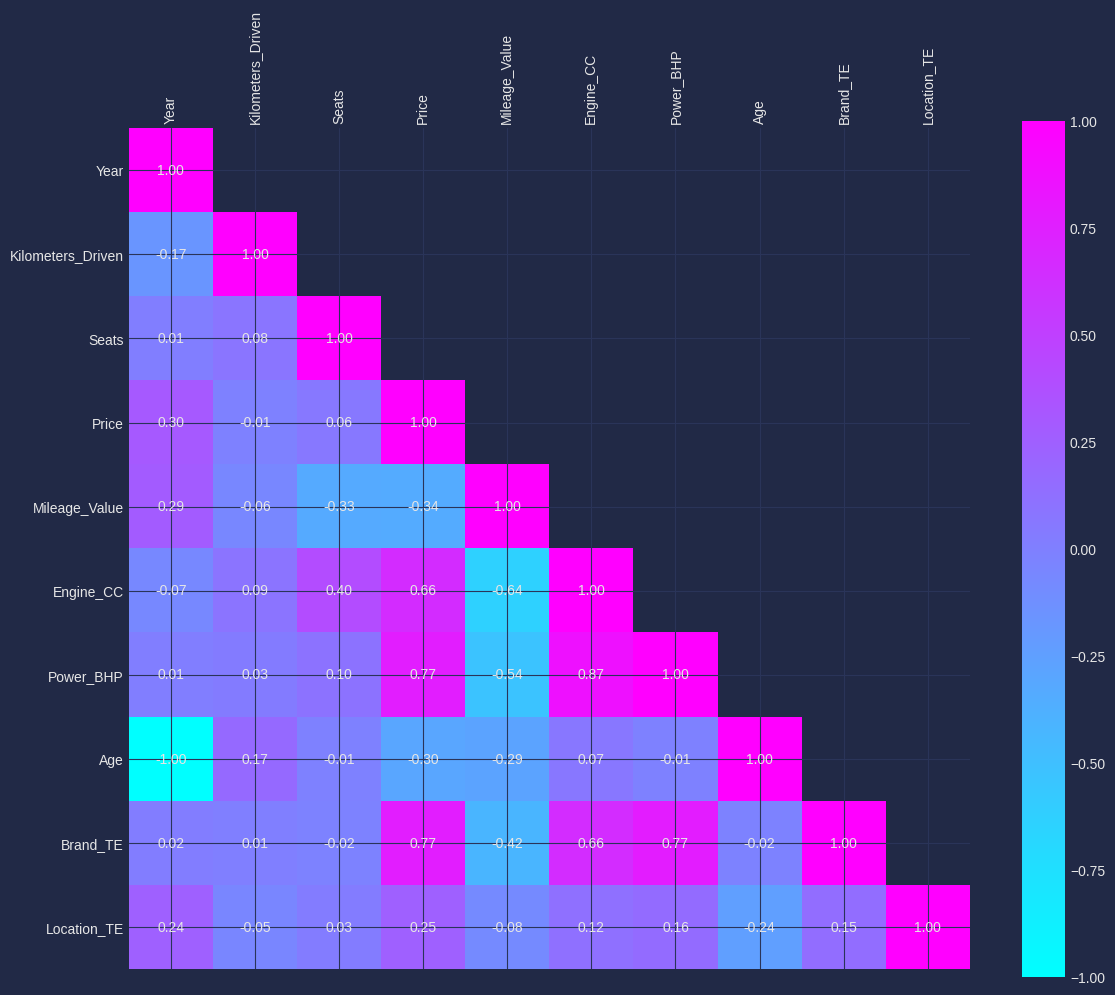

In [40]:
corr = num_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
corr_masked = corr.mask(mask)

fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(corr_masked, vmin=-1, vmax=1)
fig.colorbar(cax)

for i in range(corr_masked.shape[0]):
    for j in range(corr_masked.shape[1]):
        val = corr_masked.iloc[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", va='center', ha='center')

ax.set_xticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticks(range(len(corr.columns)))
ax.set_yticklabels(corr.columns)

plt.tight_layout()
plt.show()

In [41]:
X = add_constant(num_df.drop(columns=['Price']))
vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif_data.sort_values('VIF', ascending=False))

             feature       VIF
1               Year       inf
7                Age       inf
5          Engine_CC  7.349352
6          Power_BHP  7.152255
8           Brand_TE  2.576872
4      Mileage_Value  1.938181
3              Seats  1.804299
9        Location_TE  1.103694
2  Kilometers_Driven  1.046439
0              const  0.000000


In [42]:
df_encoded = df_encoded.drop(columns=['Year'])

In [43]:
num_cols = df_encoded.select_dtypes(include=['int64','float64']).drop(columns=['Price'])
X = add_constant(num_cols)
vif = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
vif.sort_values('VIF', ascending=False)

,feature,VIF
0,const,212.220329
4,Engine_CC,7.349352
5,Power_BHP,7.152255
7,Brand_TE,2.576872
3,Mileage_Value,1.938181
2,Seats,1.804299
6,Age,1.294226
8,Location_TE,1.103694
1,Kilometers_Driven,1.046439


### Мини-вывод по корреляционной матрице и VIF

#### 1. Корреляционная матрица  
- **`Power_BHP`** - **`Price`** ≈ **0.77**. Наиболее сильная положительная связь: чем мощнее двигатель, тем выше цена.  
- **`Brand_TE`** - **`Price`** ≈ **0.77**. Средняя цена по бренду отлично отражает рыночную стоимость.  
- **`Engine_CC`** - **`Price`** ≈ **0.56**. Более крупный объём двигателя даёт более высокую цену.  
- **`Mileage_Value`** - **`Price`** ≈ **0.34**. Экономичные машины (больший пробег на топливе) стоят дороже.  
- **`Age`** - **`Price`** ≈ **0.30**. Новые автомобили (меньший возраст) имеют более высокую цену.  
- **`Location_TE`** - **`Price`** ≈ **0.25**. Учтены региональные ценовые особенности.  
- **`Kilometers_Driven`** - **`Price`** ≈ **–0.01**. Практически отсутствует прямая линейная связь.  
- **`Seats`** - **`Price`** ≈ **0.06**. Слабо положительная связь - признак низкого влияния.

#### 2. Мультиколлинеарность (VIF)  
- **`const`** (интерсепт): VIF ≈ 212 - интерсепт всегда полностью мультиколинеарен, **игнорируется**.  
- **`Year`** и **`Age`**: VIF = ∞ - один из них удалил (`Year`).  
- **`Engine_CC`** и **`Power_BHP`**: VIF ≈ 7 (<10) - допустимо, но потенциально стоит ввести `Specific_Power = Power_BHP/Engine_CC`.  
- Остальные признаки: VIF ≤ 3 — мультиколлинеарность не критична.

#### 3. Что сделано и зачем  
1. **Корреляционный анализ** выявил наиболее сильные линейные связи с ценой, чтобы фокусироваться на информативных фичах.  
2. **VIF** дал количественную оценку «перекрытия» информации между признаками и показал, что нужно:  
   - Удалить **`Year`**, оставить **`Age`**.  
   - Рассмотреть `Specific_Power` для снижения оставшейся мультиколлинеарности между `Engine_CC` и `Power_BHP`.  
3. **Дальнейшие шаги**:   
   - Добавить `Specific_Power`.  
   - Оценить постепенное исключение слабых признаков (`Kilometers_Driven`, `Seats`) при отборе.  
   - Перейти к финальному отбору признаков и моделированию.

## Добавляем новые показатели и проводим небольшой EDA

In [44]:
df_encoded['Specific_Power'] = df_encoded['Power_BHP'] / df_encoded['Engine_CC']
df_encoded['Age2']           = df_encoded['Age'] ** 2
df_encoded['Kilometers2']    = df_encoded['Kilometers_Driven'] ** 2

In [45]:
df_encoded[['Specific_Power','Age2','Kilometers2']].describe()

,Specific_Power,Age2,Kilometers2
count,5874.000000,5874.000000,5.874000e+03
mean,0.068697,142.812904,1.189274e+10
std,0.012911,82.535965,5.513740e+11
min,0.023842,36.000000,2.924100e+04
25%,0.061601,81.000000,1.117649e+09
50%,0.067174,121.000000,2.769022e+09
75%,0.075120,169.000000,5.242955e+09
max,0.153421,729.000000,4.225000e+13


Построим:
1. **Гистограммы** распределений (`hist`) для трёх новых фичей, чтобы увидеть форму распределения.  
2. **Scatter-plots** новых фичей против `Price`, чтобы оценить их связь с целевой переменной.

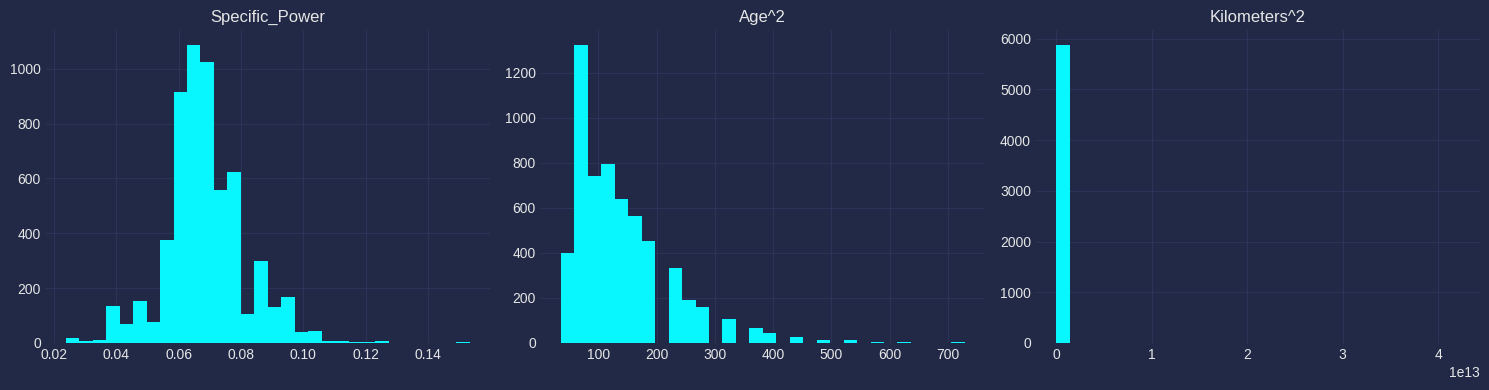

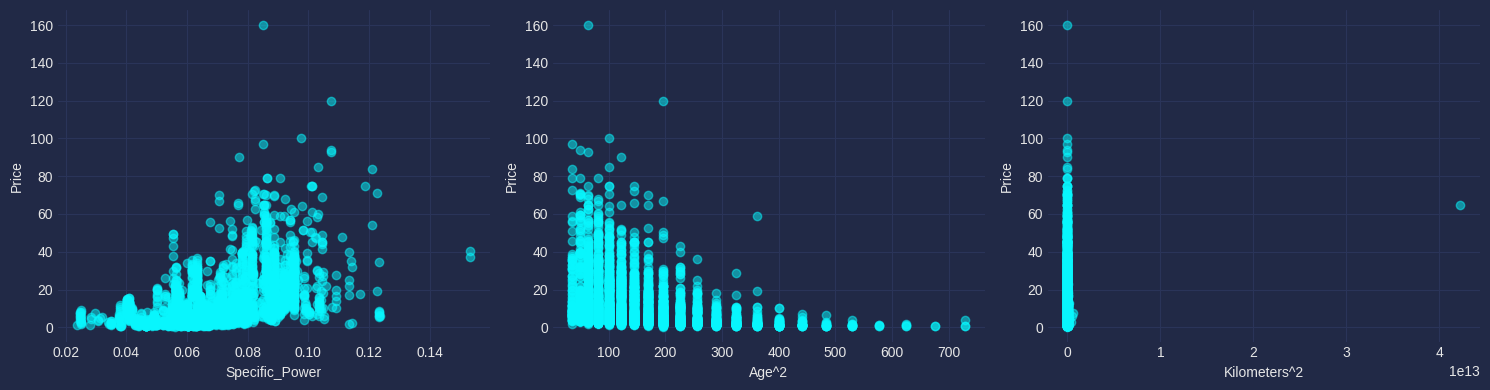

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(df_encoded['Specific_Power'], bins=30)
axes[0].set_title('Specific_Power')
axes[1].hist(df_encoded['Age2'], bins=30)
axes[1].set_title('Age^2')
axes[2].hist(df_encoded['Kilometers2'], bins=30)
axes[2].set_title('Kilometers^2')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].scatter(df_encoded['Specific_Power'], df_encoded['Price'], alpha=0.5)
axes[0].set_xlabel('Specific_Power'); axes[0].set_ylabel('Price')
axes[1].scatter(df_encoded['Age2'], df_encoded['Price'], alpha=0.5)
axes[1].set_xlabel('Age^2'); axes[1].set_ylabel('Price')
axes[2].scatter(df_encoded['Kilometers2'], df_encoded['Price'], alpha=0.5)
axes[2].set_xlabel('Kilometers^2'); axes[2].set_ylabel('Price')
plt.tight_layout()
plt.show()

### Интерпретация EDA новых фичей и дальнейшие шаги

1. `Specific_Power`  
- Распределение близко к нормальному, scatter показывает умеренную положительную корреляцию с ценой.  
- Оставляем без изменений.

2. `Age^2`  
- Правосторонняя скошенность, scatter демонстрирует обратную зависимость: более «старые» машины (больший Age^2) стоят дешевле.  
- Признак информативен, но лучше будет в нашем случае опробовать лог-преобразование - это и сделаем.

3. `Kilometers^2`  
- Сильно правостороннее распределение: практически все точки концентрируются у низких значений, а огромные квадраты пробега создают шум.  
- Scatter показывает, что зависимость почти не различима из-за экстремальных величин.

In [47]:
df_encoded['Log_Kilometers'] = np.log1p(df_encoded['Kilometers_Driven'])
df_encoded['Log_Age'] = np.log1p(df_encoded['Age'])

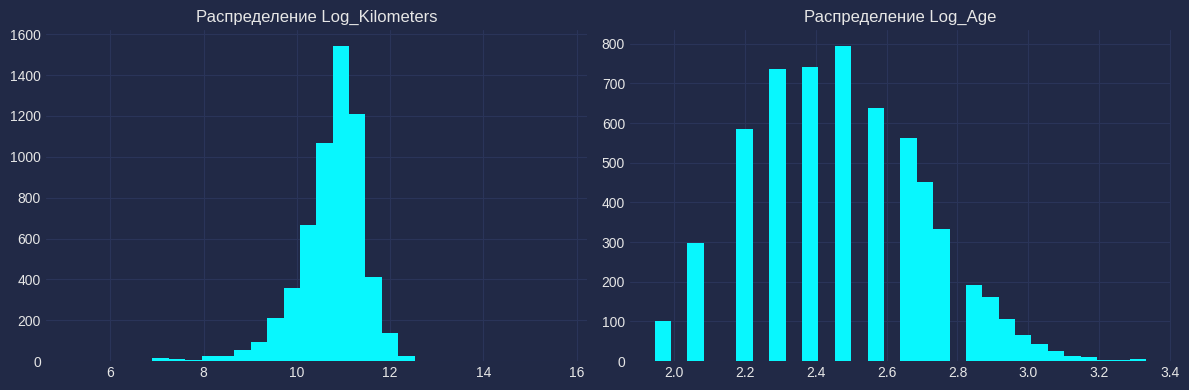

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_encoded['Log_Kilometers'], bins=30)
axes[0].set_title('Распределение Log_Kilometers')

axes[1].hist(df_encoded['Log_Age'], bins=30)
axes[1].set_title('Распределение Log_Age')

plt.tight_layout()
plt.show()

1. **Log_Kilometers**  
   - После лог-преобразования распределение почти симметричное, концентрируется вокруг 10–12.  
   - Устранены экстремальные правые выбросы, теперь модельу будет проще учесть влияние пробега.

2. **Log_Age**  
   - Значения лежат в диапазоне ~2.0–3.3, распределение стало более «колоколообразным» с умеренным правым хвостом.  
   - Лог-возраст позволяет снизить влияние очень старых машин и сгладить квадратичный признак.

## Отбор признаков с помощью RFE

Перед тем как перейти к моделированию, нам нужно выбрать из большого набора фич наиболее информативные:

- **Что отбираем?**  
  Отберём **10 признаков**, которые дают наибольший вклад в объяснение вариации `Price`.  

- **Почему именно RFE?**  
  - Позволяет последовательно исключать наименее важные признаки, основываясь на устойчивом базовом алгоритме (Ridge).  
  - Снижает риск переобучения и «проклятие размерности», ускоряет обучение моделей.  
  - Даёт явный список наиболее значимых переменных, упрощая интерпретацию.


Поехалии

Формируем матрицу признаков X и вектор y

In [49]:
print("Текущие колонки в df_encoded:\n", df_encoded.columns.tolist())

Текущие колонки в df_encoded:
 ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price', 'Mileage_Value', 'Engine_CC', 'Power_BHP', 'Age', 'Fuel_Type_Diesel', 'Fuel_Type_LPG', 'Fuel_Type_Petrol', 'Transmission_Manual', 'Owner_Type_Fourth & Above', 'Owner_Type_Second', 'Owner_Type_Third', 'Mileage_Unit_kmpl', 'Brand_TE', 'Location_TE', 'Specific_Power', 'Age2', 'Kilometers2', 'Log_Kilometers', 'Log_Age']


In [50]:
drop_cols = ['Price', 'Mileage', 'Engine', 'Power']

In [51]:
X = df_encoded.drop(columns=drop_cols)
y = df_encoded['Price']

RFE на базе Ridge

In [52]:
estimator = Ridge(alpha=1.0, random_state=42)
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X, y)

In [53]:
selected_features = X.columns[selector.support_].tolist()
print("Отобранные признаки (10):")
for f in selected_features:
    print("–", f)

Отобранные признаки (10):
– Age
– Fuel_Type_Diesel
– Fuel_Type_LPG
– Fuel_Type_Petrol
– Owner_Type_Fourth & Above
– Owner_Type_Second
– Mileage_Unit_kmpl
– Brand_TE
– Specific_Power
– Log_Age


### Итоговый набор признаков и обоснование
#### Зачем мы использовали RFE
- **Объективность**: RFE (Recursive Feature Elimination) последовательно удаляет наименее важные признаки, основываясь на «реальном» вкладе каждого из них в предсказание модели (здесь — Ridge).  
- **Управление размерностью**: из большого числа фич RFE оставляет фиксированное количество (я выбрал 10), минимизируя риск «проклятия размерности» и переобучения.  
- **Учет коллинеарности**: метод автоматически отбрасывает признаки, чья информация уже частично дублируется другими (например, `Engine_CC` и `Power_BHP` в пользу `Specific_Power`).

#### Почему не всегда стоит слепо полагаться на RFE
- **Доменные знания**: некоторые признаки (например, `Mileage_Value`, `Location_TE`) логично учитывать, даже если их «важность» в базовом Ridge-модели чуть ниже.  
- **Избежание «черного ящика»**: ручной отбор позволяет сохранить интерпретируемость и доверие к модели, поэтому немного подредактируем необходимый для нас набор переменных

#### Используемые признаки:

1. **Log_Age** (`np.log1p(Age)`). Сглаживает влияние возраста автомобиля, убирает выбросы «очень старых» машин.  
2. **Log_Kilometers** (`np.log1p(Kilometers_Driven)`). Лог-пробег более равномерно распределён и лучше отражает износ.  
3. **Specific_Power** (`Power_BHP / Engine_CC`). Отношение мощности к объёму двигателя: ключевой показатель динамики и «качественности» мотора.  
4. **Brand_TE** (Target-encoding бренда). Средняя историческая цена по бренду, отражает рыночную престижность.  
5. **Location_TE** (Target-encoding локации). Средняя цена по городу, учитывает региональные ценовые различия.  
6. **Fuel_Type_Diesel**, **Fuel_Type_LPG**. Дамми-признаки для типов топлива (базовая категория — Petrol).  
7. **Transmission_Manual**. Дамми: Manual vs Automatic.  
8. **Owner_Type_Second**, **Owner_Type_Third & Above**. Дамми для истории владельцев (базовая — First).  
9. **Mileage_Unit_kmpl**. Дамми: kmpl vs km/kg (базовая — km/kg).  

**Почему именно эти признаки?**  
- Они охватывают все ключевые аспекты, влияющие на цену: возраст, пробег, мотор, бренд и регион, тип топлива и трансмиссии, историю владельцев и эффективность расхода.  
- Лог-преобразования (`Log_Age`, `Log_Kilometers`) устраняют сильную скошенность и делают распределения более «модельными».  
- `Specific_Power` заменяет два коррелированных признака (`Power_BHP`, `Engine_CC`), снижая мультиколлинеарность и акцентируя отношение мощности к объёму.  
- Target-encoding (`Brand_TE`, `Location_TE`) упрощает кодирование высококардинальных категорий и привносит количественную информацию о каждом значении.  
- One-hot дамми-признаки для оставшихся категориальных переменных захватывают их разброс без чрезмерного роста размерности.

## Самая интересная часть с обучением

### Обоснование разбиения на Train / Validation / Test

Сразу скажу, что буду делить именно так и объясню, почему именно так
1. **Раздельная валидация гиперпараметров**  
   - **Train** (70 %) — подгоняем веса моделей и отбираем признаки.  
   - **Validation** (15 %) — на ней выбираем гиперпараметры (α для Ridge, глубину дерева и т. д.) без «заглядывания» в тест.  
   - **Test** (15 %) — только для итоговой оценки, гарантируя независимость от этапа подбора.

2. **Почему не просто Train/Test?**  
   - При одном только разбиении на train и test гиперпараметры подбираются «на вслепую» (grid/RandomSearch) по тестовой метрике, что ведёт к **утечке информации** и слишком оптимистичной оценке.  
   - Трёхсекционное разбиение устраняет этот риск и позволяет **объективно** оценить обобщающую способность модели.

### Выбранная метрика и её обоснование

- **Основная метрика — RMSE** (Root Mean Squared Error)  
  – Измеряется в тех же единицах (лакхах).  
  – Сильно штрафует крупные ошибки, важные в ценообразовании автомобилей.  
- **Дополнительно**:  
  - **MAE** (Mean Absolute Error) для устойчивой оценки при выбросах.  
  - **R²** (коэффициент детерминации) для понимания доли объяснённой дисперсии.

Формируем X и y

In [54]:
df_encoded.columns

Index(['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price',
       'Mileage_Value', 'Engine_CC', 'Power_BHP', 'Age', 'Fuel_Type_Diesel',
       'Fuel_Type_LPG', 'Fuel_Type_Petrol', 'Transmission_Manual',
       'Owner_Type_Fourth & Above', 'Owner_Type_Second', 'Owner_Type_Third',
       'Mileage_Unit_kmpl', 'Brand_TE', 'Location_TE', 'Specific_Power',
       'Age2', 'Kilometers2', 'Log_Kilometers', 'Log_Age'],
      dtype='object')

In [55]:
selected_features = [
    'Log_Age', 'Log_Kilometers', 'Specific_Power',
    'Brand_TE', 'Location_TE',
    'Fuel_Type_Diesel', 'Fuel_Type_LPG',
    'Transmission_Manual',
    'Owner_Type_Second', 'Owner_Type_Third', 'Owner_Type_Fourth & Above',
    'Mileage_Unit_kmpl'
]
X = df_encoded[selected_features]
y = df_encoded['Price']

Разбиение: 70% train, 15% validation, 15% test

In [56]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=59
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=59
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (4111, 12) (4111,)
Validation: (881, 12) (881,)
Test: (882, 12) (882,)


### Dummy baseline

In [57]:
baseline = DummyRegressor(strategy='mean').fit(X_train, y_train)
results = {
    'Baseline': {
        'RMSE': mean_squared_error(y_valid, baseline.predict(X_valid), squared=False),
        'MAE' : mean_absolute_error(y_valid, baseline.predict(X_valid)),
        'R2'  : r2_score(y_valid, baseline.predict(X_valid))
    }
}
results

{'Baseline': {'RMSE': 9.714100921585311,
  'MAE': 6.754443028324936,
  'R2': -0.00903165937804662}}

Настройка кросс-валидации

In [58]:
kf = KFold(n_splits=5, shuffle=True, random_state=59)

In [59]:
def fit_and_eval(name, estimator, param_grid=None):
    if param_grid:
        gs = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error',
                          cv=kf, n_jobs=-1)
        gs.fit(X_train, y_train)
        pred = gs.predict(X_valid)
        results[name] = {
            'best_params': gs.best_params_,
            'RMSE': mean_squared_error(y_valid, pred, squared=False),
            'MAE': mean_absolute_error(y_valid, pred),
            'R2': r2_score(y_valid, pred)
        }
    else:
        estimator.fit(X_train, y_train)
        pred = estimator.predict(X_valid)
        results[name] = {
            'best_params': None,
            'RMSE': mean_squared_error(y_valid, pred, squared=False),
            'MAE': mean_absolute_error(y_valid, pred),
            'R2': r2_score(y_valid, pred)
        }

In [60]:
fit_and_eval('LinearRegression', LinearRegression())
fit_and_eval('Ridge', Ridge(random_state=42), {'alpha': [0.1, 1.0, 10.0]})
fit_and_eval('Lasso', Lasso(random_state=42, max_iter=10000), {'alpha': [0.001, 0.01, 0.1]})
fit_and_eval('RandomForest', RandomForestRegressor(random_state=42),
             {'n_estimators': [100, 200], 'max_depth': [None, 10]})
fit_and_eval('XGBoost', XGBRegressor(random_state=42, verbosity=0),
             {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]})

In [61]:
res_df = pd.DataFrame(results).T[['best_params','RMSE','MAE','R2']]
res_df.sort_values(by='RMSE')

,best_params,RMSE,MAE,R2
XGBoost,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}",2.921425,1.409801,0.908738
RandomForest,"{'max_depth': None, 'n_estimators': 200}",3.042163,1.495847,0.901039
Ridge,{'alpha': 0.1},5.090936,3.095505,0.722863
Lasso,{'alpha': 0.001},5.096348,3.095345,0.722273
LinearRegression,NaN,5.105277,3.101651,0.721299
Baseline,NaN,9.714101,6.754443,-0.009032


## Итоги валидации моделей

| Модель             | RMSE (valid) | MAE (valid) | R^2 (valid)  | Лучшие гиперпараметры                    |
|--------------------|--------------|-------------|-------------|------------------------------------------|
| Baseline           | 9.71         | 6.75        | –0.009      | —                                        |
| LinearRegression   | 5.11         | 3.10        | 0.721       | —                                        |
| Ridge              | 5.09         | 3.10        | 0.723       | α = 0.1                                  |
| Lasso              | 5.10         | 3.10        | 0.722       | α = 0.001                                |
| RandomForest       | 3.04         | 1.50        | 0.901       | n_estimators = 200, max_depth = None     |
| XGBoost            | **2.92**     | **1.41**    | **0.909**   | learning_rate = 0.1, max_depth = 6, n_estimators = 200 |

1. **Baseline** (DummyRegressor) дал RMSE ≈ 9.71 — модель без признаков не годится.  
2. **Линейные модели** (LR/Ridge/Lasso) снизили RMSE до ~5.1, но всё ещё сильно уступают деревьям и бустингу.  
3. **RandomForest** RMSE ≈ 3.04, R² ≈ 0.90 — хороший результат, учитывая сложность задачи.  
4. **XGBoost** оказался лучшим: RMSE ≈ 2.92, MAE ≈ 1.41, R² ≈ 0.909 — сильный прогноз и значительное улучшение по сравнению с лесом.

**Лучшая модель:** XGBoost с параметрами `{learning_rate: 0.1, max_depth: 6, n_estimators: 200}`.

## Окончательная проверка на тестовой выборке

Объединяем Train + Validation

In [62]:
X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

Создаём финальную модель XGBoost с найденными параметрами

In [63]:
best_params = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
final_xgb = XGBRegressor(**best_params, random_state=42, verbosity=0)

Обучаем на объединённом наборе

In [64]:
final_xgb.fit(X_train_full, y_train_full)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Предсказываем на тестовой выборке

In [66]:
y_pred_test = final_xgb.predict(X_test)

print("XGBoost на тесте - RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))
print("XGBoost на тесте - MAE :", mean_absolute_error(y_test, y_pred_test))
print("XGBoost на тесте - R2  :", r2_score(y_test, y_pred_test))

XGBoost на тесте - RMSE: 4.228617105452807
XGBoost на тесте - MAE : 1.7144886766296399
XGBoost на тесте - R2  : 0.8468533655578794


## Итоговое обоснование разбиения и финального обучения

1. **Исходное разбиение (70 / 15 / 15)**  
   - **Train (70 %)** - для обучения моделей и подготовки признаков.  
   - **Validation (15 %)** - для честного подбора гиперпараметров и выбора лучшей модели без утечки информации в тест.  
   - **Test (15 %)** - полностью оторванная от процесса подбора и валидации выборка для окончательной оценки.

2. **Обучение финальной модели на Train+Validation**  
   - После того как оптимальные гиперпараметры XGBoost найдены на валидации (learning_rate=0.1, max_depth=6, n_estimators=200), мы **объединяем Train и Validation** (85 % данных) для обучения финальной модели.  
   - Это позволяет задействовать все доступные «не тестовые» данные и повысить обобщающую способность, сохранив тестовую выборку в чистоте.

3. **Оценка на Test**  
   - Тестовая метрика показывает истинную производительность на новых данных:  
     - **RMSE ≈ 4.23** лакхов  
     - **MAE  ≈ 1.71** лакхов  
     - **R^2   ≈ 0.847**  
   - Результаты несколько хуже, чем на валидации (RMSE ≈ 2.92), что естественно из-за отсутствия утечки информации и лёгкого переобучения на валидационной выборке.

4. **Вывод по модели**  
   - **XGBoost** с подобранными гиперпараметрами — это наш **лучший прогнозист**, демонстрирующий высокую объясняющую способность (R^2 ≈ 0.85) и приемлемый уровень ошибки (RMSE ≈ 4.2 лакхов) на полностью независимых данных.  
   - Такой результат подтверждает, что я построил устойчивую и надёжную модель для прогнозирования цены подержанных автомобилей
